In [1]:
# Monte-Carlo playoff odds
# Generate my own playoff odds

# For now, I'm focusing on the mechanics of the simulation, and less so on the inputs (e.g., the projected team quality)
# So I'm using 538's win probabilities for each game, rather than computing my own

# I'm also using 538's results/schedule data, because it is so easy to use

import pandas as pd
import numpy as np

In [2]:
# Read in the 538 dataset, which has a row for each game in the current season (played or unplayed)
gms = pd.read_csv('https://projects.fivethirtyeight.com/mlb-api/mlb_elo_latest.csv')
#gms = pd.read_csv('../data/538/mlb-elo/mlb_elo_latest.csv')
gms

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,rating_prob2,rating1_post,rating2_post,score1,score2
0,2022-10-05,2022,0,NaN,LAD,COL,1604.797760,1472.520826,0.710868,0.289132,...,NaN,NaN,NaN,NaN,0.723387,0.276613,NaN,NaN,NaN,NaN
1,2022-10-05,2022,0,NaN,SEA,DET,1524.337226,1451.512688,0.635843,0.364157,...,NaN,NaN,NaN,NaN,0.622726,0.377274,NaN,NaN,NaN,NaN
2,2022-10-05,2022,0,NaN,SDP,SFG,1511.860691,1531.550690,0.506202,0.493798,...,NaN,NaN,NaN,NaN,0.559583,0.440417,NaN,NaN,NaN,NaN
3,2022-10-05,2022,0,NaN,NYM,WSN,1535.209697,1431.603957,0.675805,0.324195,...,NaN,NaN,NaN,NaN,0.683656,0.316344,NaN,NaN,NaN,NaN
4,2022-10-05,2022,0,NaN,MIL,ARI,1520.117053,1466.163589,0.610339,0.389661,...,NaN,NaN,NaN,NaN,0.628387,0.371613,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2425,2022-04-07,2022,0,NaN,ATL,CIN,1555.630840,1501.967218,0.609942,0.390058,...,58.198554,53.297336,18.664382,15.512738,0.620108,0.379892,1552.570297,1501.193092,3.0,6.0
2426,2022-04-07,2022,0,NaN,WSN,NYM,1476.319846,1495.202033,0.507365,0.492635,...,46.506602,48.182760,-10.890192,-33.183129,0.495889,0.504111,1467.302390,1522.210391,1.0,5.0
2427,2022-04-07,2022,0,NaN,STL,PIT,1524.880454,1456.114951,0.630416,0.369584,...,57.273136,46.669517,27.921385,2.182563,0.650312,0.349688,1503.439418,1444.031029,9.0,0.0
2428,2022-04-07,2022,0,NaN,KCR,CLE,1480.923133,1501.256999,0.505276,0.494724,...,50.288294,59.572636,7.862364,30.139987,0.476089,0.523911,1473.144618,1491.474766,3.0,1.0


In [3]:
gms.columns

Index(['date', 'season', 'neutral', 'playoff', 'team1', 'team2', 'elo1_pre',
       'elo2_pre', 'elo_prob1', 'elo_prob2', 'elo1_post', 'elo2_post',
       'rating1_pre', 'rating2_pre', 'pitcher1', 'pitcher2', 'pitcher1_rgs',
       'pitcher2_rgs', 'pitcher1_adj', 'pitcher2_adj', 'rating_prob1',
       'rating_prob2', 'rating1_post', 'rating2_post', 'score1', 'score2'],
      dtype='object')

In [4]:
# Split out the games that have been played vs those remaining
played = gms.dropna(subset=['score1']) # games that have a score
remain = gms.loc[gms.index.difference(played.index)] # all other games
played.shape, remain.shape

((1435, 26), (995, 26))

# Define some functions that will be used in the simulation

In [5]:
def compute_standings(gms_played):
    margins = gms_played['score1']-gms_played['score2']
    winners = pd.Series(np.where(margins>0, gms_played['team1'], gms_played['team2']))
    losers  = pd.Series(np.where(margins<0, gms_played['team1'], gms_played['team2']))
    standings = pd.concat([winners.value_counts().rename('W'), losers.value_counts().rename('L')], axis=1)
    return standings

compute_standings(played)

,W,L
NYY,66,31
HOU,64,32
LAD,64,30
NYM,59,37
ATL,58,39
SDP,54,43
MIL,53,43
TOR,53,43
TBD,52,43
MIN,52,44


In [6]:
# This is the source data for the mapping of teams to divisions/leagues
div_text = '''
NLW: ARI COL LAD SDP SFG
NLE: ATL FLA NYM PHI WSN
ALW: SEA ANA HOU OAK TEX
ALE: TBD TOR BAL NYY BOS
ALC: MIN CHW CLE KCR DET
NLC: STL MIL CHC PIT CIN
'''

divs = {line.split(': ')[0]: line.split(': ')[1].split(' ') for line in div_text.strip().split('\n')}
teams = pd.DataFrame(pd.concat([pd.Series({team: div for team in teams}) for (div, teams) in divs.items()]).rename('div'))
teams['lg'] = teams['div'].str[0]
teams

,div,lg
ARI,NLW,N
COL,NLW,N
LAD,NLW,N
SDP,NLW,N
SFG,NLW,N
ATL,NLE,N
FLA,NLE,N
NYM,NLE,N
PHI,NLE,N
WSN,NLE,N


In [7]:

def sim_rem_games(remain):
    # Generate a random number for each game
    randoms = pd.Series(np.random.rand(len(remain)), index=remain.index)

    # Figure out the winners and losers
    winners = pd.Series(np.where(randoms<remain['rating_prob1'], remain['team1'], remain['team2']))
    losers = pd.Series(np.where(randoms>remain['rating_prob1'], remain['team1'], remain['team2']))

    # Compute and return the standings
    standings = pd.concat([winners.value_counts().rename('W'), losers.value_counts().rename('L')], axis=1)
    for col in standings.columns: # convert to int
        standings[col] = standings[col].fillna(0).astype(int)
    return standings

sim_rem_games(remain)

,W,L
NYY,46,19
PHI,45,22
SFG,42,25
NYM,41,25
CHW,40,26
TEX,39,29
LAD,38,30
TBD,38,29
SEA,37,29
HOU,36,30


In [8]:
cur_standings = compute_standings(played)
rem_standings = sim_rem_games(remain)
full_standings = cur_standings+rem_standings
full_standings

,W,L
ANA,75,87
ARI,69,93
ATL,88,74
BAL,80,82
BOS,81,81
CHC,64,98
CHW,93,69
CIN,64,98
CLE,91,71
COL,70,92


In [9]:
# find playoff teams
def add_playoff_seeds(standings):
    standings['wpct'] = standings['W'] / (standings['W'] + standings['L'])

    # Merge in the div/lg data
    standings['div'] = teams['div']
    standings['lg'] = teams['lg']

    # Rather than model out all the tie-breakers, I'm assuming that they are all random (not exactly true, but close enough),
    # and so I'm just generating a random number for each team, and we break ties by comparing that random num for each of the tied teams.
    # This is *so* much simpler and faster than modeling all the different scenarios.
    # It might be worth modeling them out with 1-2 days left in the season, but for most of the season, I way prefer using the random num to break ties
    standings['rand'] = np.random.rand(len(standings))

    # Now sort, and break ties using the rand
    sorted = standings.sort_values(by=['wpct', 'rand'], ascending=False)

    # div_rank is nice to have, but somewhat expensive to compute
    #standings['div_rank'] = sorted.groupby('div').cumcount()+1
    #standings['div_win'] = standings['div_rank'] == 1

    # Set div_win False as default, then set it True for div winners
    standings['div_win'] = False
    standings.loc[sorted.groupby('div').head(1).index, 'div_win'] = True
    standings['lg_rank'] = standings.sort_values(by=['div_win', 'wpct', 'rand'], ascending=False).groupby('lg').cumcount()+1
    return standings.sort_values(['lg', 'lg_rank'])

     

add_playoff_seeds(full_standings)

,W,L,wpct,div,lg,rand,div_win,lg_rank
NYY,103,59,0.635802,ALE,A,0.298292,True,1
HOU,98,64,0.604938,ALW,A,0.304956,True,2
CHW,93,69,0.574074,ALC,A,0.554078,True,3
CLE,91,71,0.561728,ALC,A,0.953612,False,4
TBD,90,72,0.555556,ALE,A,0.442481,False,5
TOR,90,72,0.555556,ALE,A,0.339647,False,6
SEA,89,73,0.549383,ALW,A,0.872925,False,7
BOS,81,81,0.500000,ALE,A,0.134602,False,8
BAL,80,82,0.493827,ALE,A,0.391686,False,9
MIN,77,85,0.475309,ALC,A,0.119353,False,10


In [10]:
%%prun -s cumulative # This runs the code profiler, which creates data I can use to find opportunities for me to speed up the code

[add_playoff_seeds(full_standings) for _ in range(1000)]
None # This is to suppress printing the output, which is 1000 lines of the same list of teams

         11604933 function calls (11473933 primitive calls) in 5.638 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    5.638    5.638 {built-in method builtins.exec}
        1    0.003    0.003    5.638    5.638 <string>:3(<module>)
        1    0.003    0.003    5.635    5.635 <string>:3(<listcomp>)
     1000    0.026    0.000    5.632    0.006 <ipython-input-9-f5dfa596ebf3>:2(add_playoff_seeds)
     3000    0.004    0.000    2.449    0.001 _decorators.py:302(wrapper)
     3000    0.024    0.000    2.442    0.001 frame.py:6269(sort_values)
     3000    0.092    0.000    1.719    0.001 sorting.py:285(lexsort_indexer)
     7000    0.050    0.000    1.257    0.000 categorical.py:365(__init__)
    16000    0.042    0.000    1.242    0.000 frame.py:3463(__getitem__)
     1000    0.005    0.000    1.131    0.001 groupby.py:3040(cumcount)
51000/35000    0.030    0.000    0.894    0.000 groupby.py:90

In [11]:
def finish_one_season(incoming_standings, remain):
    rem_standings = sim_rem_games(remain)
    full_standings = incoming_standings+rem_standings
    full_standings = add_playoff_seeds(full_standings)
    return full_standings

finish_one_season(cur_standings, remain)

,W,L,wpct,div,lg,rand,div_win,lg_rank
NYY,108,54,0.666667,ALE,A,0.281863,True,1
HOU,103,59,0.635802,ALW,A,0.428125,True,2
CLE,88,74,0.543210,ALC,A,0.928569,True,3
TBD,93,69,0.574074,ALE,A,0.393446,False,4
TOR,89,73,0.549383,ALE,A,0.843488,False,5
MIN,85,77,0.524691,ALC,A,0.321861,False,6
BOS,83,79,0.512346,ALE,A,0.806536,False,7
CHW,82,80,0.506173,ALC,A,0.974741,False,8
SEA,80,82,0.493827,ALW,A,0.037476,False,9
ANA,73,89,0.450617,ALW,A,0.789723,False,10


In [12]:

def sim_1_season(incoming_standings, remain, i):
    standings = finish_one_season(incoming_standings, remain)
    standings['iter'] = i
    standings = standings.reset_index().rename(columns={'index': 'team'}).set_index(['team', 'iter'])
    return standings

def sim_n_seasons(incoming_standings, remain, n):
    return pd.concat([sim_1_season(incoming_standings, remain, i) for i in range(n)])

sim_results = sim_n_seasons(cur_standings, remain, 10)
sim_results

,,W,L,wpct,div,lg,rand,div_win,lg_rank
team,iter,,,,,,,,
NYY,0,109,53,0.672840,ALE,A,0.174630,True,1
HOU,0,105,57,0.648148,ALW,A,0.089720,True,2
MIN,0,90,72,0.555556,ALC,A,0.647022,True,3
SEA,0,86,76,0.530864,ALW,A,0.221950,False,4
TBD,0,85,77,0.524691,ALE,A,0.075749,False,5
...,...,...,...,...,...,...,...,...,...
PIT,9,73,89,0.450617,NLC,N,0.849640,False,11
CIN,9,70,92,0.432099,NLC,N,0.519350,False,12
COL,9,66,96,0.407407,NLW,N,0.117868,False,13


In [13]:
# Count the number of div/wc/playoff appearances by team from a set of results

# Championship weights by seed position
weights = {i: 1/16 for i in range(1,7)}
weights[1] = 1/8
weights[2] = 1/8

def summarize_sim_results(df_results):
    counts = df_results.query('lg_rank <= 6').reset_index()[['team', 'lg_rank']].value_counts().unstack()
    mean_wins = sim_results.groupby('team')['W'].mean().rename('mean_wins')
    summary = pd.merge(left=mean_wins, right=counts, on='team', how='left')
    for col in counts.columns:
        summary[col] = summary[col].fillna(0).astype(int)    

    summary['div_wins'] = summary[range(1, 4)].sum(axis=1)
    summary['playoffs'] = summary[range(1, 7)].sum(axis=1)
    summary['champ_shares'] = (summary[range(1,7)] * np.array(weights)).sum(axis=1)
    return summary

summarize_sim_results(sim_results)

,mean_wins,1,2,3,4,5,6,div_wins,playoffs,champ_shares
team,,,,,,,,,,
ANA,72.5,0,0,0,0,0,0,0,0,0.0000
ARI,68.1,0,0,0,0,0,0,0,0,0.0000
ATL,93.1,0,3,0,2,5,0,3,10,0.8125
BAL,75.5,0,0,0,0,0,0,0,0,0.0000
BOS,79.6,0,0,0,0,0,0,0,0,0.0000
CHC,68.7,0,0,0,0,0,0,0,0,0.0000
CHW,86.0,0,0,3,1,1,2,3,7,0.4375
CIN,70.8,0,0,0,0,0,0,0,0,0.0000
CLE,82.7,0,0,1,0,0,4,1,5,0.3125


In [14]:
#%%prun -s cumulative # This runs the code profiler, which creates data I can use to find opportunities for me to speed up the code

sim_results = sim_n_seasons(cur_standings, remain, 10*1000)
summarize_sim_results(sim_results)

,mean_wins,1,2,3,4,5,6,div_wins,playoffs,champ_shares
team,,,,,,,,,,
ANA,73.1643,0,0,0,2,5,31,0,38,2.3750
ARI,70.0207,0,0,0,0,0,5,0,5,0.3125
ATL,95.3118,114,3880,173,4221,1217,288,4167,9893,867.9375
BAL,76.0116,0,0,0,18,60,132,0,210,13.1250
BOS,81.3979,0,1,0,227,681,1075,1,1984,124.0625
CHC,69.1233,0,0,0,0,0,2,0,2,0.1250
CHW,85.3872,0,7,3977,135,647,1182,3984,5948,372.1875
CIN,68.4177,0,0,3,0,0,2,3,5,0.3125
CLE,82.0374,0,1,1354,83,337,888,1355,2663,166.5000


In [15]:
sim_results.groupby('iter')['W'].max().median()

109.0

In [16]:
summary = summarize_sim_results(sim_results)
print(summary.to_string())

      mean_wins     1     2     3     4     5     6  div_wins  playoffs  champ_shares
team                                                                                 
ANA     73.1643     0     0     0     2     5    31         0        38        2.3750
ARI     70.0207     0     0     0     0     0     5         0         5        0.3125
ATL     95.3118   114  3880   173  4221  1217   288      4167      9893      867.9375
BAL     76.0116     0     0     0    18    60   132         0       210       13.1250
BOS     81.3979     0     1     0   227   681  1075         1      1984      124.0625
CHC     69.1233     0     0     0     0     0     2         0         2        0.1250
CHW     85.3872     0     7  3977   135   647  1182      3984      5948      372.1875
CIN     68.4177     0     0     3     0     0     2         3         5        0.3125
CLE     82.0374     0     1  1354    83   337   888      1355      2663      166.5000
COL     69.8491     0     0     0     0     0     2   

In [17]:
# How many games does each team win in each seeding?
sim_results.query('lg_rank <= 6').groupby(['team', 'lg_rank'])['W'].mean().unstack()

lg_rank,1,2,3,4,5,6
team,,,,,,
ANA,NaN,NaN,NaN,86.500000,85.600000,83.516129
ARI,NaN,NaN,NaN,NaN,NaN,82.000000
ATL,102.517544,98.227577,94.190751,94.360341,91.201315,88.645833
BAL,NaN,NaN,NaN,87.777778,86.416667,84.409091
BOS,NaN,94.000000,NaN,89.352423,87.236417,85.499535
CHC,NaN,NaN,NaN,NaN,NaN,83.000000
CHW,NaN,94.857143,88.490822,88.592593,87.081917,85.395093
CIN,NaN,NaN,83.000000,NaN,NaN,81.500000
CLE,NaN,96.000000,87.454210,88.192771,86.703264,84.974099


In [18]:
# How many wins do teams have in division-winning seasons?
sim_results.query('div_win').groupby('team')['W'].mean()

team
ATL     98.177346
BOS     94.000000
CHW     88.502008
CIN     83.000000
CLE     87.460517
HOU    104.230369
LAD    107.706218
MIL     90.618240
MIN     88.638704
NYM     98.617504
NYY    105.520571
PHI     94.063492
SDP     98.230769
SEA     99.666667
STL     89.305635
TBD     97.000000
TOR     99.215686
Name: W, dtype: float64

In [19]:
# How often do teams win the division when they win 95 games?
finishes = sim_results.query('W>=95').groupby('team').agg(num_seasons=('div_win', len), div_wins=('div_win', sum))
finishes['pct_win'] = finishes['div_wins']/finishes['num_seasons']
finishes


,num_seasons,div_wins,pct_win
team,,,
ATL,5882,3729,0.633968
BOS,6,0,0.000000
CHW,93,93,1.000000
CLE,11,11,1.000000
HOU,9937,9934,0.999698
LAD,9993,9983,0.998999
MIL,931,925,0.993555
MIN,172,172,1.000000
NYM,7021,5262,0.749466


In [20]:
pads95 = sim_results.query('team=="SDP" and W>=95').reset_index()['iter']
sim_results.query('iter in @pads95 and div=="NLW"').groupby('team')['W'].mean()

team
ARI     69.349544
COL     69.080041
LAD    106.445795
SDP     96.303951
SFG     81.611955
Name: W, dtype: float64

In [21]:
remain.tail(10)

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,rating_prob2,rating1_post,rating2_post,score1,score2
985,2022-07-25,2022,0,NaN,OAK,HOU,1461.478265,1573.466244,0.376014,0.623986,...,41.785136,51.878520,-37.265925,-16.918650,0.328938,0.671062,NaN,NaN,NaN,NaN
986,2022-07-25,2022,0,NaN,ARI,SFG,1466.163589,1531.550690,0.440719,0.559281,...,48.387834,50.161496,-9.437982,-15.823410,0.472825,0.527175,NaN,NaN,NaN,NaN
987,2022-07-25,2022,0,NaN,MIL,COL,1520.117053,1472.520826,0.601601,0.398399,...,46.438800,52.041379,-35.362784,5.496303,0.580631,0.419369,NaN,NaN,NaN,NaN
988,2022-07-25,2022,0,NaN,KCR,ANA,1455.617534,1476.835959,0.504003,0.495997,...,49.103167,51.749784,3.633548,0.704947,0.481501,0.518499,NaN,NaN,NaN,NaN
989,2022-07-25,2022,0,NaN,CHC,PIT,1464.298101,1440.390520,0.568511,0.431489,...,47.776100,49.492696,-7.916457,7.802209,0.558298,0.441702,NaN,NaN,NaN,NaN
990,2022-07-25,2022,0,NaN,DET,SDP,1451.512688,1511.860691,0.447881,0.552119,...,44.232836,51.746989,-24.035845,-6.292924,0.403193,0.596807,NaN,NaN,NaN,NaN
991,2022-07-25,2022,0,NaN,BOS,CLE,1510.358474,1504.373791,0.543045,0.456955,...,52.646687,51.403554,3.204272,-6.524625,0.583111,0.416889,NaN,NaN,NaN,NaN
992,2022-07-25,2022,0,NaN,PHI,ATL,1518.305846,1557.548705,0.478078,0.521922,...,53.056316,60.182036,-9.804731,28.578949,0.438545,0.561455,NaN,NaN,NaN,NaN
993,2022-07-25,2022,0,NaN,BAL,TBD,1485.650123,1542.977447,0.452185,0.547815,...,48.518794,54.398453,-3.046478,5.382239,0.437919,0.562081,NaN,NaN,NaN,NaN
994,2022-07-25,2022,0,NaN,CIN,FLA,1468.336820,1481.811238,0.515143,0.484857,...,46.824267,49.959798,-15.518403,-15.900211,0.508938,0.491062,NaN,NaN,NaN,NaN


In [40]:

num_iterations = 10 * 1000



def sim_one_way(game_id, prob):
    remain.loc[game_id, 'rating_prob1'] = prob

    sim_results = sim_n_seasons(cur_standings, remain, num_iterations)
    results = summarize_sim_results(sim_results)
    wp1 = results['champ_shares'].rename(f'{prob}')
    return wp1

def sim_both_ways(game_id):
    orig_prob = remain.loc[game_id, 'rating_prob1']
    results = pd.concat([sim_one_way(game_id, prob) for prob in [0, 1]], axis=1)
    remain.loc[game_id, 'rating_prob1'] = orig_prob
    team1 = remain.loc[game_id, 'team1']
    diff = (results['1'] - results['0']).rename(team1)
    return diff


sim_both_ways(990)



team
ANA     0.2500
ARI    -0.3125
ATL    -1.1250
BAL     0.8125
BOS    -1.8125
CHC     0.1875
CHW     0.0625
CIN     0.0625
CLE    -1.0625
COL    -0.0625
DET     0.0000
FLA    -0.6250
HOU     0.0000
KCR     0.0000
LAD     0.6250
MIL     0.8125
MIN    -0.5000
NYM     0.9375
NYY     0.1250
OAK     0.0000
PHI    10.4375
PIT     0.0000
SDP   -30.4375
SEA     1.7500
SFG     7.1875
STL    12.3125
TBD     0.6250
TEX    -0.1250
TOR    -0.1250
WSN     0.0000
Name: DET, dtype: float64

In [41]:
remain

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,rating_prob2,rating1_post,rating2_post,score1,score2
0,2022-10-05,2022,0,NaN,LAD,COL,1604.797760,1472.520826,0.710868,0.289132,...,NaN,NaN,NaN,NaN,0.723387,0.276613,NaN,NaN,NaN,NaN
1,2022-10-05,2022,0,NaN,SEA,DET,1524.337226,1451.512688,0.635843,0.364157,...,NaN,NaN,NaN,NaN,0.622726,0.377274,NaN,NaN,NaN,NaN
2,2022-10-05,2022,0,NaN,SDP,SFG,1511.860691,1531.550690,0.506202,0.493798,...,NaN,NaN,NaN,NaN,0.559583,0.440417,NaN,NaN,NaN,NaN
3,2022-10-05,2022,0,NaN,NYM,WSN,1535.209697,1431.603957,0.675805,0.324195,...,NaN,NaN,NaN,NaN,0.683656,0.316344,NaN,NaN,NaN,NaN
4,2022-10-05,2022,0,NaN,MIL,ARI,1520.117053,1466.163589,0.610339,0.389661,...,NaN,NaN,NaN,NaN,0.628387,0.371613,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,2022-07-25,2022,0,NaN,DET,SDP,1451.512688,1511.860691,0.447881,0.552119,...,44.232836,51.746989,-24.035845,-6.292924,0.403193,0.596807,NaN,NaN,NaN,NaN
991,2022-07-25,2022,0,NaN,BOS,CLE,1510.358474,1504.373791,0.543045,0.456955,...,52.646687,51.403554,3.204272,-6.524625,0.583111,0.416889,NaN,NaN,NaN,NaN
992,2022-07-25,2022,0,NaN,PHI,ATL,1518.305846,1557.548705,0.478078,0.521922,...,53.056316,60.182036,-9.804731,28.578949,0.438545,0.561455,NaN,NaN,NaN,NaN
993,2022-07-25,2022,0,NaN,BAL,TBD,1485.650123,1542.977447,0.452185,0.547815,...,48.518794,54.398453,-3.046478,5.382239,0.437919,0.562081,NaN,NaN,NaN,NaN


In [42]:
next_dt = remain['date'].min()
game_ids = remain.query('date == @next_dt').index.values
game_ids

array([983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994])

In [43]:
pd.concat([sim_both_ways(game_id) for game_id in game_ids], axis=1)

,SEA,LAD,OAK,ARI,MIL,KCR,CHC,DET,BOS,PHI,BAL,CIN
team,,,,,,,,,,,,
ANA,0.0625,-0.6250,-0.7500,-0.1875,0.3125,-0.9375,-0.3750,0.8750,-0.6250,0.2500,0.1250,-0.1250
ARI,-0.0625,0.0625,0.0625,0.4375,-0.1875,0.1250,-0.3125,0.0625,-0.1250,-0.1250,0.0625,-0.1250
ATL,4.4375,-4.8750,0.6250,-0.8750,2.6250,0.7500,8.3750,3.5625,-2.6250,-49.3125,-6.2500,-0.1875
BAL,-0.3125,-1.6250,0.1250,-0.1250,0.8125,0.2500,-1.6875,1.4375,0.3125,-3.4375,7.3125,1.2500
BOS,-10.3750,-3.1250,2.0625,-1.5000,-2.8750,-2.3125,0.0000,-1.8750,41.1875,0.4375,10.4375,-5.0625
CHC,0.0000,0.0625,-0.0625,0.0000,0.0000,-0.0625,0.1875,0.2500,-0.1875,-0.0625,-0.1250,0.0000
CHW,-19.3125,-2.8750,-3.6875,0.3125,-1.4375,-0.0625,1.7500,-1.2500,3.8125,7.7500,16.3125,9.5625
CIN,0.0000,0.0000,0.0000,0.0000,-0.0625,0.0625,0.0625,0.1250,0.0000,0.0625,-0.2500,-0.0625
CLE,0.0625,-3.0000,-1.4375,-4.3125,-0.8750,6.5000,-0.9375,3.8125,-44.0625,-4.3750,10.2500,-4.5625


In [44]:
results = _
results

,SEA,LAD,OAK,ARI,MIL,KCR,CHC,DET,BOS,PHI,BAL,CIN
team,,,,,,,,,,,,
ANA,0.0625,-0.6250,-0.7500,-0.1875,0.3125,-0.9375,-0.3750,0.8750,-0.6250,0.2500,0.1250,-0.1250
ARI,-0.0625,0.0625,0.0625,0.4375,-0.1875,0.1250,-0.3125,0.0625,-0.1250,-0.1250,0.0625,-0.1250
ATL,4.4375,-4.8750,0.6250,-0.8750,2.6250,0.7500,8.3750,3.5625,-2.6250,-49.3125,-6.2500,-0.1875
BAL,-0.3125,-1.6250,0.1250,-0.1250,0.8125,0.2500,-1.6875,1.4375,0.3125,-3.4375,7.3125,1.2500
BOS,-10.3750,-3.1250,2.0625,-1.5000,-2.8750,-2.3125,0.0000,-1.8750,41.1875,0.4375,10.4375,-5.0625
CHC,0.0000,0.0625,-0.0625,0.0000,0.0000,-0.0625,0.1875,0.2500,-0.1875,-0.0625,-0.1250,0.0000
CHW,-19.3125,-2.8750,-3.6875,0.3125,-1.4375,-0.0625,1.7500,-1.2500,3.8125,7.7500,16.3125,9.5625
CIN,0.0000,0.0000,0.0000,0.0000,-0.0625,0.0625,0.0625,0.1250,0.0000,0.0625,-0.2500,-0.0625
CLE,0.0625,-3.0000,-1.4375,-4.3125,-0.8750,6.5000,-0.9375,3.8125,-44.0625,-4.3750,10.2500,-4.5625


In [45]:
import seaborn as sns
%matplotlib inline

<AxesSubplot:ylabel='team'>

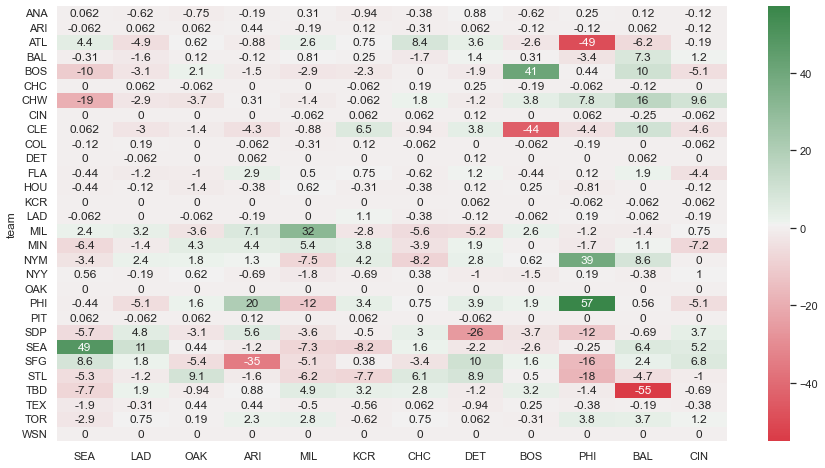

In [46]:
sns.set(rc = {'figure.figsize':(15,8)})
cmap = sns.diverging_palette(10, 133, as_cmap=True)
sns.heatmap(results, cmap=cmap, annot=True)